In [6]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# !pip install shimmy
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL_Online_Portfolio_Benchmarks.git

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [9]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [10]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-12-31'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

# TODO Drop the DOW stock
# value_to_remove = "DOW"
# # Create a new list without the specified string
# DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
# print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (22278, 8)


In [11]:
print(raw_df)

             date        open        high         low       close     volume  \
0      2009-04-01    3.717500    3.892857    3.710357    3.274471  589372000   
1      2009-04-01   34.520000   35.599998   34.209999   26.850742    9288800   
2      2009-04-01   14.770000   15.320000   14.620000    9.507454   75052800   
3      2009-04-01   18.230000   19.360001   18.180000   14.301788   96438900   
4      2009-04-01   13.687500   14.000000   13.407500   12.129695   44144400   
...           ...         ...         ...         ...         ...        ...   
22273  2023-12-29  260.670013  262.220001  259.559998  260.660004    3681900   
22274  2023-12-29   50.299999   50.570000   49.770000   49.585903   29266500   
22275  2023-12-29  376.000000  377.160004  373.480011  373.248871   18723000   
22276  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
22277  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

        tic  day  
0      AAPL    2  
1

In [12]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [13]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(raw_df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
print(processed)


Successfully added technical indicators
Successfully added turbulence index
             date        open        high         low       close     volume  \
0      2009-04-01    3.717500    3.892857    3.710357    3.274471  589372000   
1      2009-04-01   34.520000   35.599998   34.209999   26.850742    9288800   
2      2009-04-01   14.770000   15.320000   14.620000    9.507454   75052800   
3      2009-04-01   18.230000   19.360001   18.180000   14.301788   96438900   
4      2009-04-01   13.687500   14.000000   13.407500   12.129695   44144400   
...           ...         ...         ...         ...         ...        ...   
22273  2023-12-29  260.670013  262.220001  259.559998  260.660004    3681900   
22274  2023-12-29   50.299999   50.570000   49.770000   49.585903   29266500   
22275  2023-12-29  376.000000  377.160004  373.480011  373.248871   18723000   
22276  2023-12-29  260.570007  261.459991  259.670013  258.375092    4074600   
22277  2023-12-29   52.509998   52.693333   

In [14]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler


# TODO - we are using the normalized indicators here, is that okay?


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5,0.000000,1.000000,0.168245,1.000000,0.000000
1,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5,0.000000,1.000000,0.150477,1.000000,0.000000
2,2009-04-01,0.216569,0.221100,0.217204,0.153140,0.377145,INTC,0.5,0.000000,1.000000,0.120880,1.000000,0.000000
3,2009-04-01,0.047504,0.050377,0.048075,0.037650,0.302015,MSFT,0.5,0.000000,1.000000,0.148421,1.000000,0.000000
4,2009-04-01,0.052006,0.053181,0.051633,0.046583,0.130785,V,0.5,0.000000,1.000000,0.164371,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22273,2023-12-29,0.584449,0.587924,0.589654,0.605763,0.035673,BA,1.0,0.206132,0.712996,0.181645,0.559519,0.003293
22274,2023-12-29,0.737537,0.729831,0.739415,0.798699,0.147066,INTC,1.0,0.623049,0.684100,0.307706,0.581834,0.003293
22275,2023-12-29,0.979779,0.981421,0.987624,0.982597,0.058634,MSFT,1.0,0.230229,0.585081,0.105103,0.252380,0.003293
22276,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0,0.201450,0.614353,0.266411,0.368021,0.003293


In [15]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
tic,,,,,,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
INTC,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
MSFT,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
V,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713
WMT,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713,3713


In [16]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [17]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

df_train.groupby("tic").count()

,date,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
tic,,,,,,,,,,,,
AAPL,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
BA,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
INTC,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
MSFT,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
V,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
WMT,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212


# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio

In [18]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [19]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure
# Try also training a PPO agent on this same environment


environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low", 'macd',
            'rsi_30',
            'cci_30',
            'dx_30'], # Lets use the other indicators
        normalize_df=None,
        reward_scaling=1e-4,
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

agent_ppo = DRLStableAgent(env = environment)
PPO_PARAMS = {
    "n_steps": 2048,
    "batch_size": 64,
    # "ent_coef": 0.01,
    "learning_rate": 0.00025, # TODO tried raising the lr which caused vanishing problem
    "clip_range": 0.3
}

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_ppo = agent_ppo.get_model("ppo", device, model_kwargs=PPO_PARAMS, policy_kwargs=None)

# set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

Logging to results/ppo


In [20]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_ppo = DRLStableAgent.train_model(model_ppo, env=environment, episodes=1)

from finrl.config import TRAINED_MODEL_DIR

model_ppo.save(TRAINED_MODEL_DIR + "/agent_opt_ppo_features")

Max number of time steps in an episode:  3212
-----------------------------
| time/              |      |
|    fps             | 89   |
|    iterations      | 1    |
|    time_elapsed    | 22   |
|    total_timesteps | 2048 |
-----------------------------


=================================

Initial portfolio value:1000000

Final portfolio value: 307893.8125

Final accumulative portfolio value: 0.3078938125

Maximum DrawDown: -0.8065701454546369

Sharpe ratio: -0.3502425125297511

=================================

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.21e+03     |
|    ep_rew_mean          | -0.000118    |
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 2            |
|    time_elapsed         | 49           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0146556385 |
|    clip_fraction        | 0.0507       |
|    clip_range           | 0.3          |
|    entropy_loss         | -9.91        |
|    explained_variance   | -2.02        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0686      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.013       |
|    std                  | 0.993        |
|    value_loss           | 0.00549      |
------------------------------------------


In [21]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

-1
Empty DataFrame
Columns: [date, open, high, low, close, volume, tic, day, macd, rsi_30, cci_30, dx_30, turbulence]
Index: []


In [22]:
PPO_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptimizationEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'macd',
            'rsi_30',
            'cci_30',
            'dx_30'],
    normalize_df=None,
        reward_scaling=1e-4,
)


environment_2022 = PortfolioOptimizationEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'macd',
            'rsi_30',
            'cci_30',
            'dx_30'],
    normalize_df=None,
        reward_scaling=1e-4,
)

environment_2023 = PortfolioOptimizationEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low",'macd',
            'rsi_30',
            'cci_30',
            'dx_30'],
    normalize_df=None,
        reward_scaling=1e-4,
)


print(model_ppo._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2021)
PPO_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
PPO_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_ppo, environment_2022)
PPO_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
PPO_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_ppo, environment_2023)
# PPO_results["2023"]["value"] = environment_2023._asset_memory["final"]
# PPO_results["2023"]["date"] = environment_2023._date_memory

IndexError: list index out of range

In [ ]:
print(len(df_2021['date'].unique()) - 1)

print(len(PPO_results['date']))

251
2960


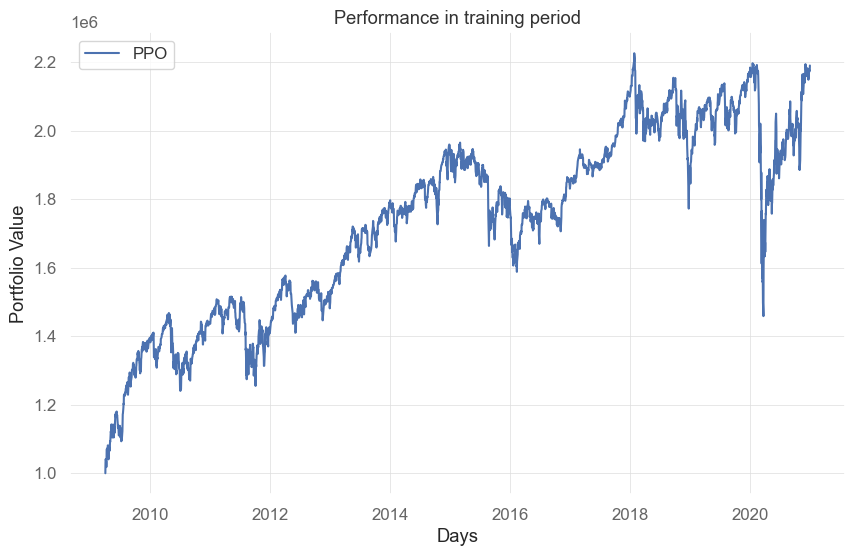

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [ ]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(TEST_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

Initial portfolio value:1000000
Final portfolio value: 7939990.5
Final accumulative portfolio value: 7.9399905
Maximum DrawDown: -0.33119683748792905
Sharpe ratio: 1.1059658411352369
Total commission cost: 87048.9333885957
Initial portfolio value:1000000
Final portfolio value: 1213571.75
Final accumulative portfolio value: 1.21357175
Maximum DrawDown: -0.06613164306698993
Sharpe ratio: 1.6868934949510972
Total commission cost: 2419.6817123437067
Initial portfolio value:1000000
Final portfolio value: 921180.1875
Final accumulative portfolio value: 0.9211801875
Maximum DrawDown: -0.21710123827308292
Sharpe ratio: -0.31400578127715933
Total commission cost: 2328.912423899281


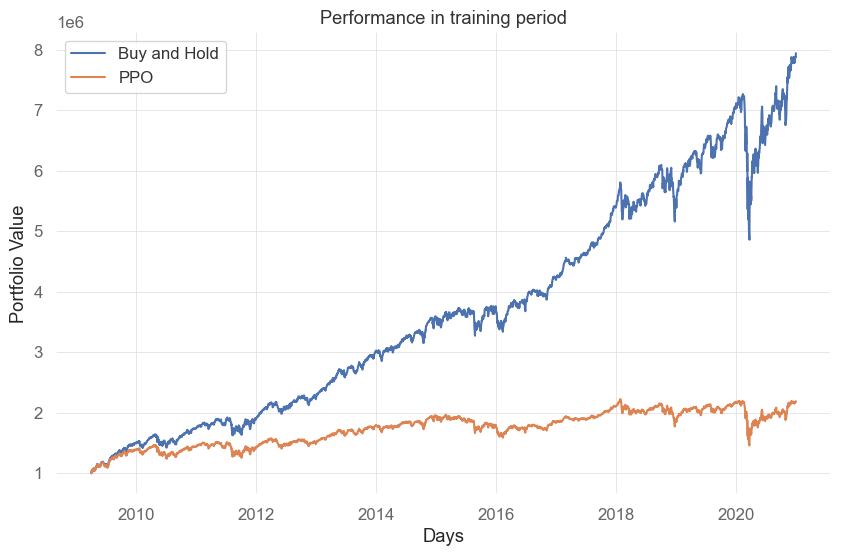

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(PPO_results["date"], PPO_results["training"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

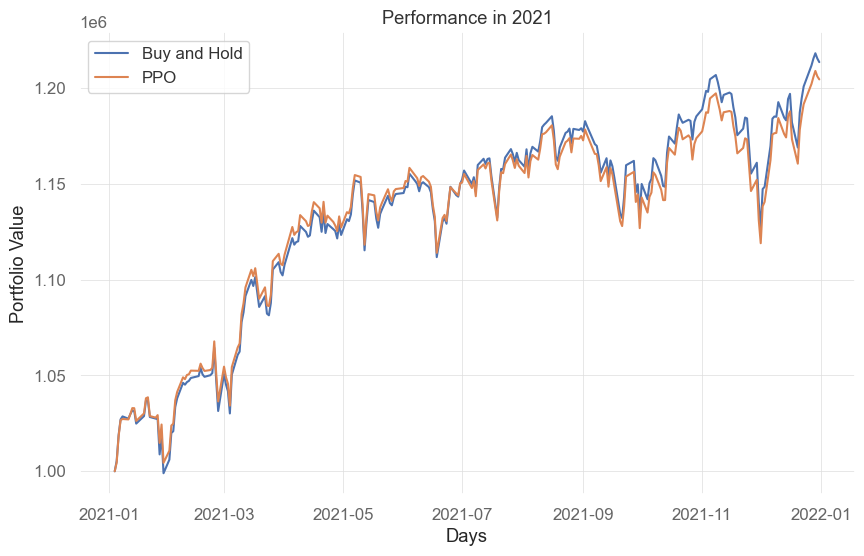

In [ ]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2021"]["date"], PPO_results["2021"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

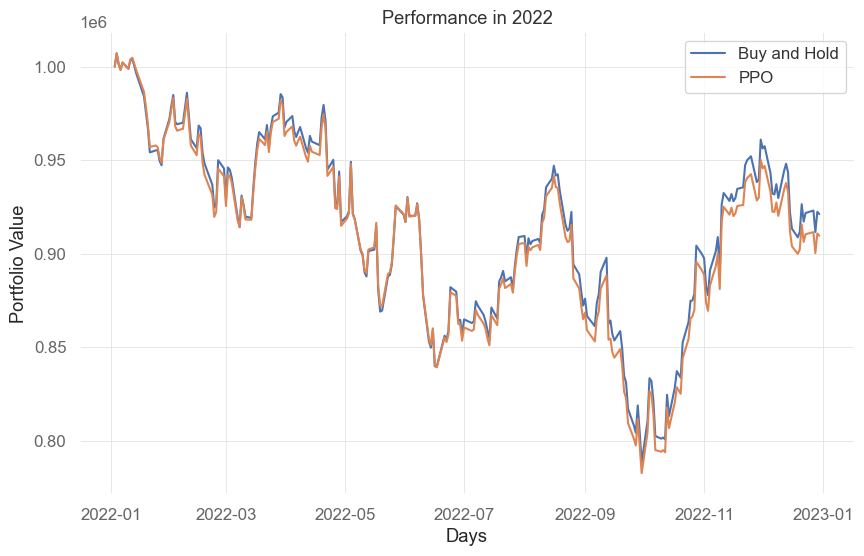

In [ ]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(PPO_results["2022"]["date"], PPO_results["2022"]["value"], label="PPO")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [ ]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(PPO_results["2023"]["date"], PPO_results["2023"]["value"], label="PPO")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()

In [ ]:
import shutil
shutil.make_archive('train', 'zip', '../content')

from google.colab import files
files.download("train.zip")